# Collecting and analyzing data about Stanford tuition


> *A little more than one year ago Stanford students paid no tuition fee. Just one year ago a charge of 40 dollars per quarter was made to all students for the first time in the history of the institution. In less than one year from now every student entering the University for the first time will pay a tuition fee of 225 dollars a year.*

> *What does this all mean? Every Stanford Alumnus will and should be asking himself this question: Is Stanford no longer to be the institution of the "good old days"? Does it mean that the poor man is no longer to be welcome to the campus; that Stanford is to be a "rich man's college"; that the Stanford "S" will henceforth be spelled with the "&#36;" sign?*

> *&mdash; ["The Second Tuition Bomb" - The Stanford Illustrated Review (books.google.com)](https://books.google.com/books?id=dMDmAAAAMAAJ&lpg=PT5&ots=JM5OTxRHRl&dq=stanford%20first%20tuition%20increase&pg=PT5#v=onepage&q&f=false)* 

The above lament comes from the editorial page of the Stanford Illustrated Review in its __January 1921 edition__. Ninety-five years later, tuition is still (mostly) mandatory. While we can't ascertain if Stanford (or "&#36;tanford") has continued to stray from the "good old days" from before 1920, we can at least analyze the raw tuition fee numbers as Stanford lists them on its [Administration & Finances Facts page](http://facts.stanford.edu/administration/finances). Let's scrape the data from the HTML data and programmatically chart the data to better see the trend. 

This web-scraping-to-Matplotlib-tutorial comes from the [COMM 277A: Computational Journalism 2015 lesson plan](http://www.compjour.org/weeks/6/). It should work with an [Anaconda installation of Python 3.x](https://www.continuum.io/downloads)





## Download the data

Scroll down the [Stanford Finances page](http://facts.stanford.edu/administration/finances) to find this HTML table:

![image stanford-tuition-html-table.png](images/stanford-tuition-html-table.png)

Note that not every year is listed. For consecutive years in which the tuition remained the same, the year column contains the starting year of the tuition change. For example, in the 1950s, tuition was pegged at 660 dollars, until 1960, when it was raised to 1,005 dollars:

| Academic year | Tuition |
|---------------|---------|
| 1940-41       | 345    |
| 1950-51       | 660    |
| 1960-61       | 1,005  |


This is what the HTML looks like:

```html
<table class="table table-striped data-table col-1-text">
    <thead>
        <tr>
            <th>Academic Year</th>
            <th>Tuition</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td width="49%">1920-21</td>
            <td width="51%">$120</td>
        </tr>
        <tr>
            <td>1930-31</td>
            <td>$300</td>
        </tr>
        <tr>
            <td>1940-41</td>
            <td>$345</td>
        </tr>
        <tr>
            <td>1950-51</td>
            <td>$660</td>
        </tr>
    </tbody>
</table>
```


Below is the Python to scrape it, with the use of the [lxml library for HTML parsing](http://lxml.de/):


In [1]:
# scraping stanford's tuition page

import pandas as pd
import csv
from lxml import html
import requests
import re
# live site is at: "http://facts.stanford.edu/administration/finances"
# mirror can be found here:
# http://stash.compjour.org/mirrors/facts.stanford.edu/administration/finances.html
url = 'http://facts.stanford.edu/administration/finances'
resp = requests.get(url)
doc = html.fromstring(resp.text)
table = doc.cssselect('table')[3]

rows = []
for trs in table.cssselect('tr')[1:]:
    yr, cost = [t.text for t in trs]
    # cut off the "1959" part of "1950-1959"
    rows.append( [int(yr.split('-')[0]), int(re.sub('\D', '', cost))])

# alternatively
# rows = [( int(tds[0].text.split('-')[0]), int(re.sub('\D', '', tds[1].text))) for tds in
#              [trs for trs in table.cssselect('tr')[1:]]]

Now we need to fill in the gaps between the decades; for years in which no tuition is specified, we assume it's the same tuition as the previous year.

Warning: convoluted code to follow

In [4]:
# make a row for every year
tuition_rows = []
for row in rows:
    if len(tuition_rows) > 0:
        lastyr, lastcost = tuition_rows[-1]
        tuition_rows.extend([[lastyr + i, lastcost] for i in range(1, row[0] - lastyr)])
    tuition_rows.append(row)

# Now make a dataframe
tuition_df = pd.DataFrame(tuition_rows, columns = ['year', 'tuition'])

Let's check the first and last few rows with the `head()` and `tail()` methods of the dataframe:

In [5]:
tuition_df.head()

,year,tuition
0,1920,120
1,1921,120
2,1922,120
3,1923,120
4,1924,120


In [6]:
tuition_df.tail()

,year,tuition
91,2011,40050
92,2012,41250
93,2013,42690
94,2014,44184
95,2015,45729


Looks good!

### Make an inflation-calcuation function

Of course, the value of a dollar has changed just as much as the actual tuition fee. Let's gather CPI/inflation data from OKFN (the latest year in the set is 2014):

[US Consumer Price Index and Inflation (CPI)](http://data.okfn.org/data/core/cpi-us)


In [19]:
########################
# Set up inflation calculator

url = 'https://raw.githubusercontent.com/datasets/cpi-us/master/data/cpiai.csv'
cpidata = list(csv.reader(requests.get(url).text.splitlines()))
cpidf = pd.DataFrame(cpidata[1:], columns = cpidata[0])
cpidf = pd.DataFrame.convert_objects(cpidf, convert_dates = 'coerce', convert_numeric = True)
cpimean_df = cpidf.groupby(cpidf['Date'].map(lambda x: x.year)).mean()

def adjust_for_inflation(amt, from_year, to_year=2014, max_year=2014):
    f_year = min(from_year, max_year) # don't have 2015 data
    ratio = cpimean_df['Index'][to_year] / cpimean_df['Index'][f_year]
    return int(round(ratio * amt))

tuition_df['adjusted_tuition'] = tuition_df.apply(lambda row: adjust_for_inflation(row['tuition'], row['year']), axis=1)
tuition_df.head(15)



/Users/dtown/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,year,tuition,adjusted_tuition
0,1920,120,1401
1,1921,120,1573
2,1922,120,1676
3,1923,120,1646
4,1924,120,1639
5,1925,120,1600
6,1926,120,1586
7,1927,120,1617
8,1928,120,1636
9,1929,120,1636


## Charting time


Now we can chart.


In [20]:
import matplotlib.pyplot as pyplot
# this part is needed if you are doing this in an iPython notebook
%matplotlib inline

### Tuition, sans inflation

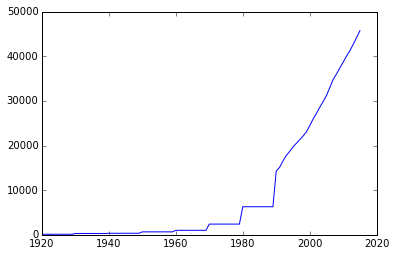

In [21]:
pyplot.plot(tuition_df['year'], tuition_df['tuition'])

### Tuition, adjusted for inflation

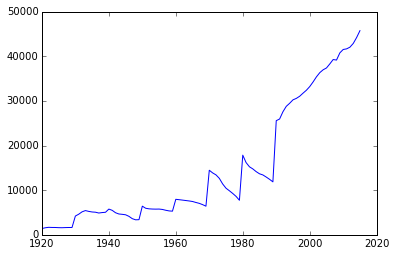

In [22]:
pyplot.plot(tuition_df['year'], tuition_df['adjusted_tuition'])

### Tuition, non-adjusted and adjusted for inflation; on the same chart

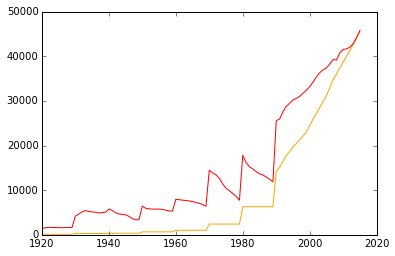

In [23]:
pyplot.plot(tuition_df['year'], tuition_df['tuition'], label = 'Unadjusted', color = 'orange')
pyplot.plot(tuition_df['year'], tuition_df['adjusted_tuition'], label = 'Adjusted', color = 'red')

## Tuition since 1990; adjusted and non-adjusted

Sometimes it's more helpful to see just the most recent couple of decades; again, unadjusted is in the orange, adjusted-for-inflation is in the red:

(0, 50000.0)

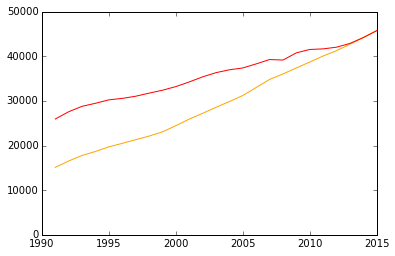

In [26]:
xdf = tuition_df[tuition_df['year'] > 1990]

pyplot.plot(xdf['year'], xdf['tuition'], label = 'Unadjusted', color = 'orange')
pyplot.plot(xdf['year'], xdf['adjusted_tuition'], label = 'Adjusted', color = 'red')
pyplot.ylim(ymin = 0)

# The good ol days for &#36;tanford?

There's a lot more to assessing the increase of tuition than tuition fees themselves. For example, student fees ([listed here](https://registrar.stanford.edu/students/tuition-and-fees)) and living costs are non-trivial factors. On the other hand, the Stanford Review editorial board's worry that [Stanford would become just a "rich man's college"](https://books.google.com/books?id=dMDmAAAAMAAJ&lpg=PT5&ots=JM5OTxRHRl&dq=stanford%20first%20tuition%20increase&pg=PT5#v=onepage&q&f=false) hasn't entirely come to pass -- Stanford has long since given free tuition to students from families from lower household incomes ([up to $125,000 -- which benefits nearly 30 percent of undergraduates](http://www.theatlantic.com/education/archive/2015/04/stanfords-tuition-giveaway-is-not-good-news/390090/)). Also worth considering: whether the _value_ of a Stanford education has increased accordingly, even since the days when [Herbert Hoover made his journey from dorm rat to builder of towers](https://books.google.com/books?id=hwnHCgAAQBAJ&pg=PT21&lpg=PT21&dq=herbert+hoover+stanford+dorm&source=bl&ots=XH2_2LPNHi&sig=oawDx4TlhDrlEGRZrG6oQbwCU54&hl=en&sa=X&ved=0ahUKEwilipng9cfLAhUO8GMKHYTLBd0Q6AEIWDAN#v=onepage&q=herbert%20hoover%20stanford%20dorm&f=false).


Those are all factors that can't be accounted for in tuition data alone; further study would require gathering tuition data from all of Stanford's peers. But it's a nice start to have Stanford's numbers in easily scrapable form. 